<a href="https://colab.research.google.com/github/ayushijainn111/E-shara_Miniproject/blob/main/03_Eshare_CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = "/content/drive/MyDrive/feature_train_test_data"

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-05-05 13:03:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-05-05 13:03:30 (82.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for our notebook
import helper_functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, walk_through_dir, unzip_data

In [ ]:
train_dir = "/content/drive/MyDrive/feature_train_test_data/reduced_train_100"
test_dir = "/content/drive/MyDrive/feature_train_test_data/reduced_test_250"

In [ ]:
# How many images/classes are there?
walk_through_dir("/content/drive/MyDrive/feature_train_test_data/reduced_train_100")

There are 41 directories and 0 images in '/content/drive/MyDrive/feature_train_test_data/reduced_train_100'.
There are 0 directories and 100 images in '/content/drive/MyDrive/feature_train_test_data/reduced_train_100/80. tall'.
There are 0 directories and 100 images in '/content/drive/MyDrive/feature_train_test_data/reduced_train_100/81. wide'.
There are 0 directories and 100 images in '/content/drive/MyDrive/feature_train_test_data/reduced_train_100/79. short'.
There are 0 directories and 100 images in '/content/drive/MyDrive/feature_train_test_data/reduced_train_100/8. Blind'.
There are 0 directories and 100 images in '/content/drive/MyDrive/feature_train_test_data/reduced_train_100/78. long'.
There are 0 directories and 94 images in '/content/drive/MyDrive/feature_train_test_data/reduced_train_100/extra'.
There are 0 directories and 100 images in '/content/drive/MyDrive/feature_train_test_data/reduced_train_100/6. Ugly'.
There are 0 directories and 100 images in '/content/drive/MyDr

In [ ]:
# How many images/classes are there in test directory
walk_through_dir("/content/drive/MyDrive/feature_train_test_data/reduced_test_250")

There are 41 directories and 0 images in '/content/drive/MyDrive/feature_train_test_data/reduced_test_250'.
There are 0 directories and 234 images in '/content/drive/MyDrive/feature_train_test_data/reduced_test_250/1. loud'.
There are 0 directories and 250 images in '/content/drive/MyDrive/feature_train_test_data/reduced_test_250/2. quiet'.
There are 0 directories and 223 images in '/content/drive/MyDrive/feature_train_test_data/reduced_test_250/3. happy'.
There are 0 directories and 97 images in '/content/drive/MyDrive/feature_train_test_data/reduced_test_250/36. light'.
There are 0 directories and 84 images in '/content/drive/MyDrive/feature_train_test_data/reduced_test_250/39. famous'.
There are 0 directories and 105 images in '/content/drive/MyDrive/feature_train_test_data/reduced_test_250/4. sad'.
There are 0 directories and 250 images in '/content/drive/MyDrive/feature_train_test_data/reduced_test_250/40. I'.
There are 0 directories and 250 images in '/content/drive/MyDrive/featu

In [ ]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_100 = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode = "categorical",
                                                                                image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE,
                                                                shuffle = False) #don't shuffle test data for prediction analysis

Found 3821 files belonging to 41 classes.
Found 8514 files belonging to 41 classes.


In [ ]:
100*41

4100

In [ ]:
# Create checkpoint callback
checkpoint_path = "eshara_39_classes_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True,
                                                         monitor = "val_accuracy",
                                                         save_best_only = True)

In [ ]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  layers.RandomZoom(0.2),
  # preprocessing.Rescaling(1/255.) #rescale inputs of images to between 0 and 1, required my model's like Resnet50
])

In [ ]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape = (224, 224, 3), name = "input_layer")
x = data_augmentation(inputs) #augment images(only happens during training phase)
x = base_model(x, training=False) #put the base model in inference mode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name ="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_100.class_names), activation="softmax", name = "output_layer")(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# Get the summary of model we've created
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool_layer           │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 41)             │        52,521 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,102,092 (15.65 MB)

 Trainable params: 52,521 (205.16 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

In [ ]:
# Fit the model
history_all_classes_10_percent = model.fit(train_data_100,
                                           epochs = 5,
                                           validation_data = test_data,
                                            validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 2034s 17s/step - accuracy: 0.0870 - loss: 3.4737 - val_accuracy: 0.0562 - val_loss: 3.3089
Epoch 2/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 95s 459ms/step - accuracy: 0.1648 - loss: 2.8031 - val_accuracy: 0.0211 - val_loss: 3.2857
Epoch 3/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 84s 474ms/step - accuracy: 0.2143 - loss: 2.5745 - val_accuracy: 0.0828 - val_loss: 2.9270
Epoch 4/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 57s 474ms/step - accuracy: 0.2563 - loss: 2.4473 - val_accuracy: 0.0953 - val_loss: 3.0243
Epoch 5/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 57s 467ms/step - accuracy: 0.2824 - loss: 2.3645 - val_accuracy: 0.0992 - val_loss: 3.1141


In [ ]:
# evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

254/267 ━━━━━━━━━━━━━━━━━━━━ 2:18 11s/step - accuracy: 0.0917 - loss: 3.2201

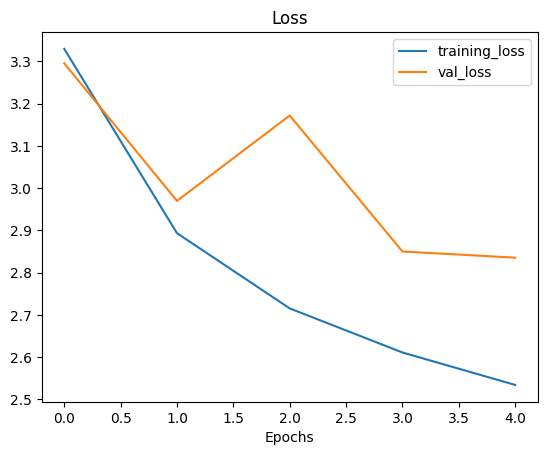

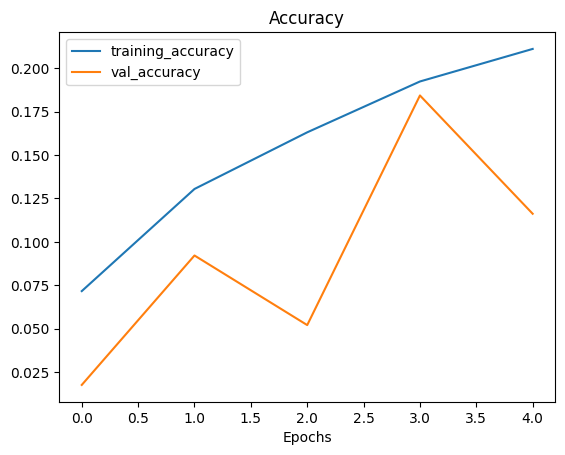

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

## Fine Tuning

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile model with lower learning rate (it's typically the best practice to lower the learning rate)
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001), #learning rate lowered by 10x
              metrics = ["accuracy"])

In [ ]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
sequential True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [ ]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# Fine tune for 5 more epochs
fine_tune_epochs = 10 #model has already done 5 epochs(feature extraction), this the total number of epochs we're after(5+5 = 10)

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs = fine_tune_epochs,
                                                     validation_data = test_data,
                                                     validation_steps = int(0.15*len(test_data)),
                                                     initial_epoch = history_all_classes_10_percent.epoch[-1])

Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 71s 468ms/step - accuracy: 0.2456 - loss: 2.4801 - val_accuracy: 0.2179 - val_loss: 2.6124
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 82s 671ms/step - accuracy: 0.2908 - loss: 2.3595 - val_accuracy: 0.2644 - val_loss: 2.5123
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 56s 455ms/step - accuracy: 0.3048 - loss: 2.2843 - val_accuracy: 0.3029 - val_loss: 2.3356
Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 81s 447ms/step - accuracy: 0.3097 - loss: 2.2491 - val_accuracy: 0.3029 - val_loss: 2.2714
Epoch 9/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 83s 460ms/step - accuracy: 0.3277 - loss: 2.2158 - val_accuracy: 0.2812 - val_loss: 2.2331
Epoch 10/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 80s 446ms/step - accuracy: 0.3351 - loss: 2.1645 - val_accuracy: 0.3125 - val_loss: 2.2154


In [ ]:
# Evaluate on the whole test data
history_all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
history_all_classes_10_percent_fine_tune_results

266/266 ━━━━━━━━━━━━━━━━━━━━ 94s 354ms/step - accuracy: 0.2570 - loss: 2.4097


[2.463632822036743, 0.2305152714252472]

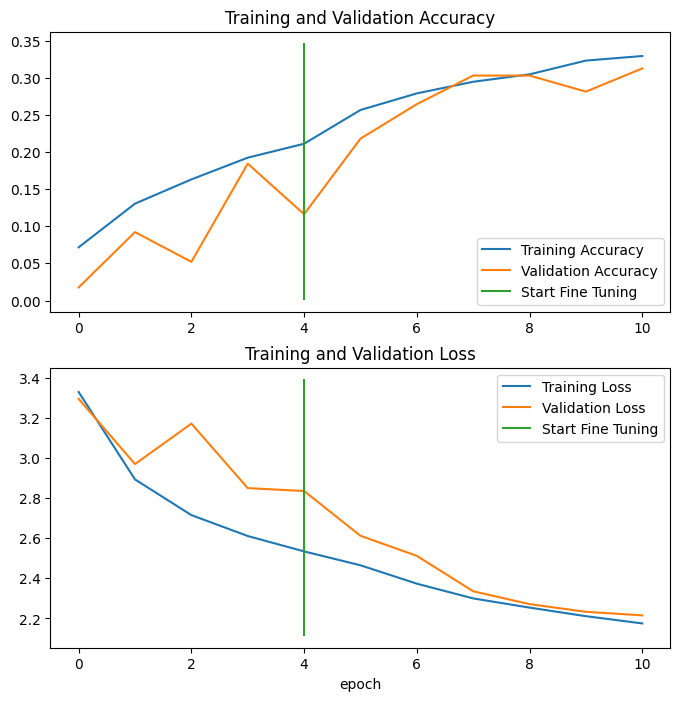

In [ ]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history = history_all_classes_10_percent,
                 new_history = history_all_classes_10_percent_fine_tune,
                 initial_epochs = 5)

In [ ]:
# Save our fine-tuned model
model.save("/content/drive/MyDrive/Eshara_assests/eshara__39_classes_10_percent_saved_model.keras")

In [ ]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Eshara_assests/eshara__39_classes_10_percent_saved_model.keras")

In [ ]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

266/266 ━━━━━━━━━━━━━━━━━━━━ 93s 327ms/step - accuracy: 0.2570 - loss: 2.4097


[2.463632822036743, 0.2305152714252472]

In [ ]:
# The results from our loaded_model (above) should be very similar to the results below
history_all_classes_10_percent_fine_tune_results

[2.463632822036743, 0.2305152714252472]

In [ ]:
# Make predictions with model
preds_probs = loaded_model.predict(test_data, verbose = 1) #set verbositiy to see how long is left

266/266 ━━━━━━━━━━━━━━━━━━━━ 95s 348ms/step


In [ ]:
len(test_data)

266

In [ ]:
266*32

8512

In [ ]:
# How many predictions are there
len(preds_probs)

8481

In [ ]:
# What's the shape of our predictions?
preds_probs.shape

(8481, 39)

In [ ]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[1.78197294e-01, 2.93798614e-02, 1.01116486e-01, 2.70401972e-04,
        1.16205701e-05, 1.28933552e-05, 8.46141629e-05, 6.60122096e-05,
        1.41480530e-04, 1.08025903e-04, 2.26511947e-05, 1.00804260e-03,
        5.77093851e-05, 6.54328178e-05, 4.87670222e-05, 3.14653298e-04,
        5.09182501e-05, 3.38609534e-04, 4.30758373e-05, 4.12634981e-05,
        1.43331519e-04, 5.05663957e-05, 1.94261636e-04, 2.69985194e-05,
        7.20467360e-05, 6.40390717e-05, 3.70714925e-02, 5.36749884e-02,
        8.19854813e-06, 3.18196714e-02, 1.33762695e-02, 1.00805745e-01,
        3.64999175e-02, 4.77161929e-02, 2.82183420e-02, 5.08637391e-02,
        8.50163177e-02, 7.51719326e-02, 1.27826035e-01],
       [1.80090457e-01, 3.78249846e-02, 1.14494681e-01, 8.99165520e-04,
        2.03581410e-04, 1.02628102e-04, 1.15679693e-04, 1.11053778e-04,
        2.16487155e-04, 2.35362066e-04, 7.67567763e-05, 6.74828014e-04,
        1.79235882e-04, 4.27587293e-05, 2.17400273e-04, 8.11939535e-04,
       

In [ ]:
# What does the first predictions probability look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([1.78197294e-01, 2.93798614e-02, 1.01116486e-01, 2.70401972e-04,
        1.16205701e-05, 1.28933552e-05, 8.46141629e-05, 6.60122096e-05,
        1.41480530e-04, 1.08025903e-04, 2.26511947e-05, 1.00804260e-03,
        5.77093851e-05, 6.54328178e-05, 4.87670222e-05, 3.14653298e-04,
        5.09182501e-05, 3.38609534e-04, 4.30758373e-05, 4.12634981e-05,
        1.43331519e-04, 5.05663957e-05, 1.94261636e-04, 2.69985194e-05,
        7.20467360e-05, 6.40390717e-05, 3.70714925e-02, 5.36749884e-02,
        8.19854813e-06, 3.18196714e-02, 1.33762695e-02, 1.00805745e-01,
        3.64999175e-02, 4.77161929e-02, 2.82183420e-02, 5.08637391e-02,
        8.50163177e-02, 7.51719326e-02, 1.27826035e-01], dtype=float32),
 39,
 np.float32(0.9999999))

In [ ]:
#  We get one prediction probability per class (in our case there;s 39 prediction probabilities)
print(f"Number of prediction probablities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like: \n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")
# print(f"The class with the highest predicted probability is: {class_names[preds_probs[0].argmax()]}")

Number of prediction probablities for sample 0: 39
What prediction probability sample 0 looks like: 
 [1.78197294e-01 2.93798614e-02 1.01116486e-01 2.70401972e-04
 1.16205701e-05 1.28933552e-05 8.46141629e-05 6.60122096e-05
 1.41480530e-04 1.08025903e-04 2.26511947e-05 1.00804260e-03
 5.77093851e-05 6.54328178e-05 4.87670222e-05 3.14653298e-04
 5.09182501e-05 3.38609534e-04 4.30758373e-05 4.12634981e-05
 1.43331519e-04 5.05663957e-05 1.94261636e-04 2.69985194e-05
 7.20467360e-05 6.40390717e-05 3.70714925e-02 5.36749884e-02
 8.19854813e-06 3.18196714e-02 1.33762695e-02 1.00805745e-01
 3.64999175e-02 4.77161929e-02 2.82183420e-02 5.08637391e-02
 8.50163177e-02 7.51719326e-02 1.27826035e-01]
The class with the highest predicted probability by the model for sample 0: 0


In [ ]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 0,  0, 31,  0,  0,  0,  0,  0,  0,  0])

In [ ]:
# How many pred classes do we have?
len(pred_classes)

8481

In [ ]:
# To get our test lables we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) #currently test lables look like [0, 0, 0, 1, .....0, 0]
y_labels[:10] #look at the first 10

[np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0)]

In [ ]:
# HOw many y_lables are there?
len(y_labels)

8481

In [ ]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true = y_labels, y_pred = pred_classes)
sklearn_accuracy

0.23051526942577527

In [ ]:
# Does this metric come close to our model;s evaluate results
import numpy as np
np.isclose(history_all_classes_10_percent_fine_tune_results[1], sklearn_accuracy)

np.True_

In [ ]:
from helper_functions import make_confusion_matrix

In [ ]:
# Get a list of all class names
class_names =test_data.class_names
class_names[:10]

['1. loud',
 '2. quiet',
 '3. happy',
 '36. light',
 '39. famous',
 '4. sad',
 '40. I',
 '41. you',
 '42. he',
 '43. she']

In [ ]:
# We need to make some changes to our make_confusion_matrix function to ensure the x-labels print veritcal y_lables
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix # import confusion_matrix from sklearn.metrics
import numpy as np
import itertools

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x_labloes vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
make_confusion_matrix(y_true = y_labels,
                      y_pred = pred_classes,
                      classes = class_names,
                      figsize = (100, 100),
                      text_size = 20,
                      savefig = True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true = y_labels,
                            y_pred = pred_classes))

              precision    recall  f1-score   support

           0       0.21      0.33      0.26       234
           1       0.41      0.33      0.37       250
           2       0.29      0.24      0.27       223
           3       0.54      0.62      0.57        97
           4       0.31      0.48      0.38        84
           5       0.83      0.36      0.50       105
           6       0.29      0.15      0.20       250
           7       0.24      0.03      0.05       250
           8       0.15      0.39      0.22       250
           9       0.09      0.06      0.08       250
          10       0.14      0.39      0.20       245
          11       0.33      0.04      0.07       250
          12       0.15      0.22      0.17       250
          13       0.78      0.44      0.56       250
          14       0.62      0.08      0.15       250
          15       0.44      0.11      0.18       250
          16       0.69      0.28      0.40       109
          17       0.29    

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_true = y_labels,
                                                    y_pred = pred_classes,
                                                    output_dict = True)
classification_report_dict

{'0': {'precision': 0.21081081081081082,
  'recall': 0.3333333333333333,
  'f1-score': 0.2582781456953642,
  'support': 234.0},
 '1': {'precision': 0.4068627450980392,
  'recall': 0.332,
  'f1-score': 0.3656387665198238,
  'support': 250.0},
 '2': {'precision': 0.29347826086956524,
  'recall': 0.242152466367713,
  'f1-score': 0.26535626535626533,
  'support': 223.0},
 '3': {'precision': 0.5357142857142857,
  'recall': 0.6185567010309279,
  'f1-score': 0.5741626794258373,
  'support': 97.0},
 '4': {'precision': 0.31007751937984496,
  'recall': 0.47619047619047616,
  'f1-score': 0.3755868544600939,
  'support': 84.0},
 '5': {'precision': 0.8260869565217391,
  'recall': 0.3619047619047619,
  'f1-score': 0.5033112582781457,
  'support': 105.0},
 '6': {'precision': 0.2890625,
  'recall': 0.148,
  'f1-score': 0.19576719576719576,
  'support': 250.0},
 '7': {'precision': 0.2413793103448276,
  'recall': 0.028,
  'f1-score': 0.05017921146953405,
  'support': 250.0},
 '8': {'precision': 0.150306

In [ ]:
class_names[38]

'99. healthy'

In [ ]:
classification_report_dict["38"]["f1-score"]

0.08239700374531835

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification  report dictionary items
for k,v in classification_report_dict.items():
  if k == "accuracy": #stop once we get to accuracy key
    break
  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'1. loud': 0.2582781456953642,
 '2. quiet': 0.3656387665198238,
 '3. happy': 0.26535626535626533,
 '36. light': 0.5741626794258373,
 '39. famous': 0.3755868544600939,
 '4. sad': 0.5033112582781457,
 '40. I': 0.19576719576719576,
 '41. you': 0.05017921146953405,
 '42. he': 0.21729490022172948,
 '43. she': 0.07637231503579953,
 '44. it': 0.202991452991453,
 '45. we': 0.07142857142857142,
 '46. you (plural)': 0.17475728155339806,
 '47. they': 0.558974358974359,
 '48. Hello': 0.14788732394366197,
 '49. How are you': 0.17834394904458598,
 '5. Beautiful': 0.4025974025974026,
 '50. Alright': 0.3023255813953488,
 '51. Good Morning': 0.07339449541284404,
 '52. Good afternoon': 0.15113350125944586,
 '53. Good evening': 0.13696060037523453,
 '54. Good night': 0.11695906432748537,
 '55. Thank you': 0.1386861313868613,
 '56. Pleased': 0.26506024096385544,
 '6. Ugly': 0.14678899082568808,
 '7. Deaf': 0.313953488372093,
 '78. long': 0.36363636363636365,
 '79. short': 0.09737827715355805,
 '8. Blind'

In [ ]:
# Turn f1-scores into dataframes for visualisation
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                         "f1-score":list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [ ]:
f1_scores

,class_names,f1-score
3,36. light,0.574163
13,47. they,0.558974
37,98. sick,0.533623
5,4. sad,0.503311
16,5. Beautiful,0.402597
4,39. famous,0.375587
1,2. quiet,0.365639
26,78. long,0.363636
25,7. Deaf,0.313953
17,50. Alright,0.302326


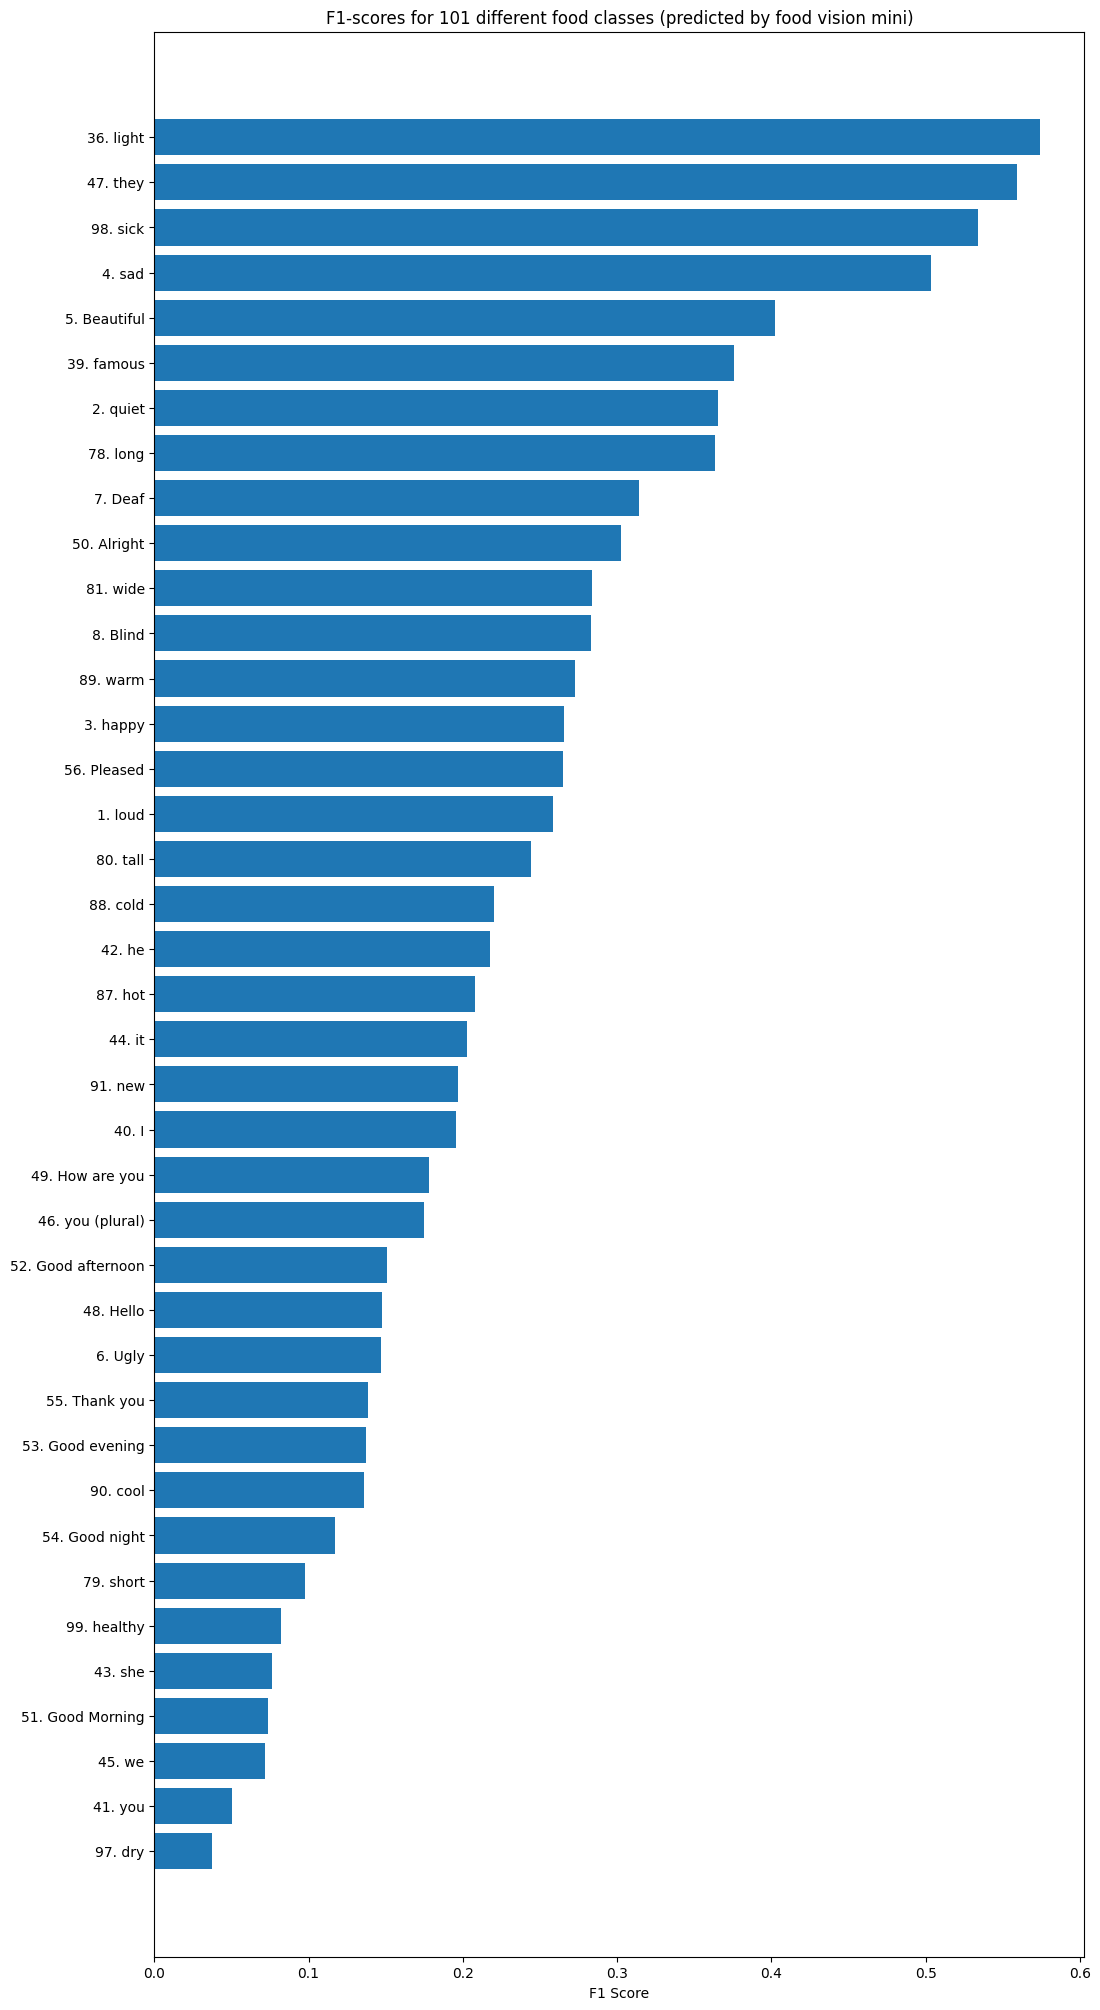

In [ ]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)  #get the f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1 Score")
ax.set_title("F1-scores for 101 different food classes (predicted by food vision mini)")
ax.invert_yaxis() #reverse the order

In [ ]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale = True):
  """
  Reads in an image from filenames, turns it into a tensor and reshapes into sepcified shape
  (img_shape, img_shape, color_channels =3).

  Args:
    filename (str): path to target image
    image_shape (int): height/width deimension of target image sixe
    scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """

  # Read in the image
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels
  # (our model is trained on images with 3 colour channels
  img = tf.image.decode_image(img, channels = 3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Scale the image (if necessary)
  if scale:
    # rescale the image(get all values between 0 and 1)
    return img/255.
  else:
    return img # dont need to rescale images for EfficientNet models in TensorFlow

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


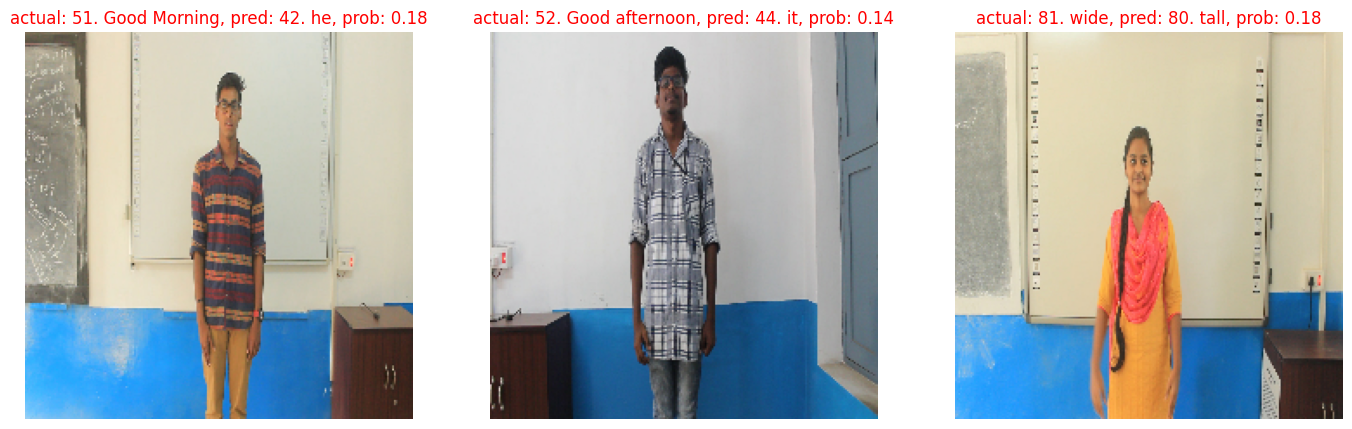

In [ ]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  # Correct the file path by adding a '/' after test_dir
  filepath = test_dir + "/" + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale = False)
  # print(img.shape)
  img_expanded = tf.expand_dims(img, axis = 0)
  # print(img_expanded.shape)
  pred_prob = model.predict(img_expanded) # get prediction probabilities away
  pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index and match it to class
  # print(pred_prob)
  # print(pred_class)

  # PLot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # if predicted class matches truth class, make the color green
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c = title_color)
  plt.axis(False)

In [ ]:
# Get all the image file path in the test dataset
filepaths = []
for filepath in test_data.list_files("/content/drive/MyDrive/openpose_train_test_data/reduced_test_250/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/drive/MyDrive/openpose_train_test_data/reduced_test_250/1. loud/1. loud_temp_MVI_5177_11.jpg',
 b'/content/drive/MyDrive/openpose_train_test_data/reduced_test_250/1. loud/1. loud_temp_MVI_5177_15.jpg',
 b'/content/drive/MyDrive/openpose_train_test_data/reduced_test_250/1. loud/1. loud_temp_MVI_5177_17.jpg',
 b'/content/drive/MyDrive/openpose_train_test_data/reduced_test_250/1. loud/1. loud_temp_MVI_5177_19.jpg',
 b'/content/drive/MyDrive/openpose_train_test_data/reduced_test_250/1. loud/1. loud_temp_MVI_5177_21.jpg',
 b'/content/drive/MyDrive/openpose_train_test_data/reduced_test_250/1. loud/1. loud_temp_MVI_5177_26.jpg',
 b'/content/drive/MyDrive/openpose_train_test_data/reduced_test_250/1. loud/1. loud_temp_MVI_5177_28.jpg',
 b'/content/drive/MyDrive/openpose_train_test_data/reduced_test_250/1. loud/1. loud_temp_MVI_5177_31.jpg',
 b'/content/drive/MyDrive/openpose_train_test_data/reduced_test_250/1. loud/1. loud_temp_MVI_5177_39.jpg',
 b'/content/drive/MyDrive/openpose_tr

In [ ]:
# 2. Create a DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis = 1), # get the max prediction prob
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes],
                        })
pred_df

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'/content/drive/MyDrive/openpose_train_test_d...,0,0,0.178197,1. loud,1. loud
1,b'/content/drive/MyDrive/openpose_train_test_d...,0,0,0.180090,1. loud,1. loud
2,b'/content/drive/MyDrive/openpose_train_test_d...,0,31,0.147169,1. loud,87. hot
3,b'/content/drive/MyDrive/openpose_train_test_d...,0,0,0.162014,1. loud,1. loud
4,b'/content/drive/MyDrive/openpose_train_test_d...,0,0,0.183000,1. loud,1. loud
...,...,...,...,...,...,...
8476,b'/content/drive/MyDrive/openpose_train_test_d...,38,32,0.118263,99. healthy,88. cold
8477,b'/content/drive/MyDrive/openpose_train_test_d...,38,36,0.093209,99. healthy,97. dry
8478,b'/content/drive/MyDrive/openpose_train_test_d...,38,32,0.092903,99. healthy,88. cold
8479,b'/content/drive/MyDrive/openpose_train_test_d...,38,35,0.100565,99. healthy,91. new


In [ ]:
# 3. Find out in our DataFrame which predictions are wrong?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'/content/drive/MyDrive/openpose_train_test_d...,0,0,0.178197,1. loud,1. loud,True
1,b'/content/drive/MyDrive/openpose_train_test_d...,0,0,0.180090,1. loud,1. loud,True
2,b'/content/drive/MyDrive/openpose_train_test_d...,0,31,0.147169,1. loud,87. hot,False
3,b'/content/drive/MyDrive/openpose_train_test_d...,0,0,0.162014,1. loud,1. loud,True
4,b'/content/drive/MyDrive/openpose_train_test_d...,0,0,0.183000,1. loud,1. loud,True


In [ ]:
# 4. Sort our DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
8405,b'/content/drive/MyDrive/openpose_train_test_d...,38,26,0.527570,99. healthy,78. long,False
8404,b'/content/drive/MyDrive/openpose_train_test_d...,38,26,0.505110,99. healthy,78. long,False
8406,b'/content/drive/MyDrive/openpose_train_test_d...,38,26,0.481080,99. healthy,78. long,False
6723,b'/content/drive/MyDrive/openpose_train_test_d...,31,26,0.465492,87. hot,78. long,False
5087,b'/content/drive/MyDrive/openpose_train_test_d...,22,15,0.453330,55. Thank you,49. How are you,False
6734,b'/content/drive/MyDrive/openpose_train_test_d...,31,26,0.446380,87. hot,78. long,False
8390,b'/content/drive/MyDrive/openpose_train_test_d...,38,26,0.441718,99. healthy,78. long,False
3466,b'/content/drive/MyDrive/openpose_train_test_d...,15,17,0.436389,49. How are you,50. Alright,False
807,b'/content/drive/MyDrive/openpose_train_test_d...,4,3,0.435249,39. famous,36. light,False
5086,b'/content/drive/MyDrive/openpose_train_test_d...,22,15,0.432593,55. Thank you,49. How are you,False


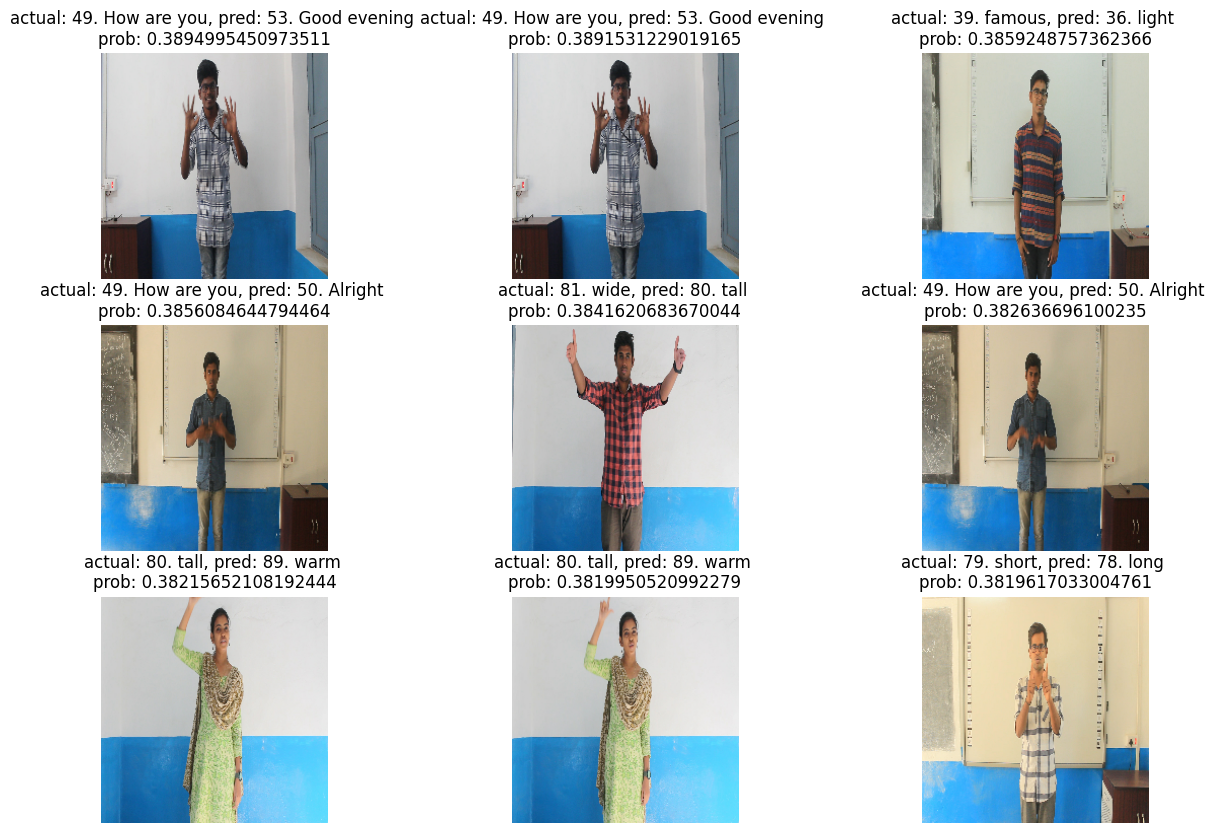

In [ ]:
# 5. visualize the test data samples which have the wrong prediction but highest pred probability
images_to_view = 9
start_index = 20
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row.img_path)
  img = load_and_prep_image(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row #only interested in a few parameters
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname} \nprob: {pred_prob}")
  plt.axis(False)